# Embedding Optimization
We will apply embedding optimization techniques to improve the quality of our embeddings for better recommendation performance. While creating the model we had a lot of options to choose from. Here we will explore some of those options and see how they affect the model performance.

In [20]:
from helpers.notebook_pipelines.yes_tuned_bow_model import run_evaluation_multi
from sentence_transformers import SentenceTransformer, util
from sklearn.feature_extraction.text import TfidfVectorizer
from helpers.functs.StudentProfile import StudentProfile
from sklearn.metrics.pairwise import cosine_similarity
from typing import Iterable, Set, Tuple, List
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch
import time
import ast

We have copied the same mock student profiles from the BoW evaluation notebook and added some extra profiles to better simulate a SBERT scenario. 

In [21]:
# Our mocked student profiles
student1 = StudentProfile(
    current_study= "Kunst & Onderzoek",
    interests=[
        "Tekenen",
        "Animatie",
        "Kunst",
        "Drama",
        "Ik hou ervan om mensen te vermaken. Dit doe ik het liefst door bijvoorbeeld te dansen, te zingen of toneelspelen. In het algemeen vind ik het fijn om creatief bezig te zijn. Ik ben graag onder de mensen."
    ],
    wanted_study_credit_range=(15, 30),
    location_preference=["Den Bosch", "Breda", "Tilburg"],
    learning_goals=["Kritisch denken", "Sociale vaardigheden", "Zelfverzekerdheid", "Ik wil o.a. leren hoe ik betere illustraties kan maken zowel analoog als digitaal."],
    level_preference=["NLQF5", "NLQF6"],
    preferred_language="NL",
    preferred_start_range="any"
)
student2 = StudentProfile(
    current_study= "Informatica",
    interests=[
        "Programmeren",
        "AI",
        "Coderen",
        "Techniek",
        "Software",
        "Ik heb werken met computers en techniek van jongs af aan al interessant gevonden. Kunstmatige intelligentie is nu ook zeker iets dat me interesseert, zeker met de sterke opkomst hiervan. Zo kun je denken aan machine learning, deep learning, etc. Ik wil me vooral bezighouden met software."
    ],
    wanted_study_credit_range=(15, 30),
    location_preference=["Den Bosch", "Breda", "Tilburg"],
    learning_goals=["Kritisch denken", "Technische Vaardigheden", "Eén van de dingen die ik wil leren is het toepassen van mijn kennis in de praktijk"],
    level_preference=["NLQF5", "NLQF6"],
    preferred_language="NL",
    preferred_start_range="any"
)
student3 = StudentProfile(
    current_study= "Psychologie",
    interests=[
        "Mensen",
        "Emoties",
        "Gedrag",
        "Psychologie",
        "Ik wil graag weten waarom mensen bepaalde dingen doen; ik wil mensen hun gedrag kunnen begrijpen. Naast hun gedrag wil ik ook leren over, persoonlijkheden en emoties. Graag wil ik mensen hun welzijn kunnen bevorderen met het gebruik van psychologische kennis."
    ],
    wanted_study_credit_range=(15, 30),
    location_preference=["Den Bosch", "Breda", "Tilburg"],
    learning_goals=["Kritisch denken", "Sociale Vaardigheden", "Ik wil leren hoe ik mensen en hun gedrag beter kan analyseren"],
    level_preference=["NLQF5", "NLQF6"],
    preferred_language="NL",
    preferred_start_range="any"
)

student4 = StudentProfile(
    current_study="Economics",
    interests=[
        "Business",
        "Entrepreneurship",
        "Strategies",
        "Branding",
        "I am a real entrepreneur. I am especially interested in how innovation, strategy, and future developments influence economic growth and organizational success"
    ],
    wanted_study_credit_range=(15, 30),
    location_preference=["Den Bosch", "Breda", "Tilburg"],
    learning_goals=["Forward thinking", "Social skill", "I want to better understand the impact of modern technologies on business models"],
    level_preference=["NLQF5", "NLQF6"],
    preferred_language="NL",
    preferred_start_range="any"
)

student5 = StudentProfile(
    current_study="Verpleegkunde, Mens en Techniek",
    interests=[
        "Zorg",
        "Gezondheid",
        "Medisch",
        "Verpleegkunde",
        "Ik ben erg geïnteresseerd in verpleegkunde en hoop ook later in een ziekenhuis omgeving te kunnen werken. Daarom wil ik ook meer praktische ervaring op doen passend bij mijn studie verpleegkunde met de module die ik kies."
    ],
    wanted_study_credit_range=(15, 30),
    location_preference=["Den Bosch", "Breda", "Tilburg"],
    learning_goals=["Sociale vaardigheden", "Persoonlijke ontwikkeling", "Ik leren hoe ik beter kan anticiperen op bepaalde zorgbehoeften"],
    level_preference=["NLQF5", "NLQF6"],
    preferred_language="NL",
    preferred_start_range="any"
)

students = [student1, student2, student3, student4, student5]

To evaluate the models performance on the datasets we will use the precision@k metric. For each student profile, we will generate recommendations using different embedding models and compute the precision@k by comparing the recommended modules against the known relevant modules for that profile. This will help us identify which embedding model performs best for our recommendation system. 

In [22]:
# Ground-truth relevant modules per student
ground_truth = {
    "student1": [388, 392, 191, 385, 386, 379, 389, 377, 391],
    "student2": [304, 305, 312, 317, 318, 322, 321, 334, 336, 340],
    "student3": [159, 290, 397, 180, 177, 208, 173, 193],
    "student4": [229, 272, 280, 279, 235, 380],
    "student5": [160, 199, 161, 163]
}

We also had a thought: `What if we use different types of preprocessing techniques?`. Different text preprocessing techniques may yield different results for each model. For instance, some models might perform better with lemmatized text, while others might benefit from retaining the original word forms. We will experiment with various preprocessing techniques to see how they impact the embedding quality and recommendation performance.

In [23]:
softNLP_df = pd.read_csv("../Data/Cleaned/cleaned_dataset_soft-NLP.csv")
hardNLP_df = pd.read_csv("../Data/Cleaned/cleaned_dataset_hard-NLP.csv")

# safely join selected columns into text (handle NaNs and non-str types)
cols = ['name', 'description', 'learningoutcomes', 'module_tags']

softNLP_module_text = (
    softNLP_df[cols]
    .fillna('')
    .astype(str)
    .agg(' '.join, axis=1)
    .str.replace(r'\s+', ' ', regex=True)
    .tolist()
)
# use the dataset 'id' column so we report the real module ids (not dataframe positional indices)
soft_module_ids = softNLP_df['id'].tolist()

hardNLP_module_text = (
    hardNLP_df[cols]
    .fillna('')
    .astype(str)
    .agg(' '.join, axis=1)
    .str.replace(r'\s+', ' ', regex=True)
    .tolist()
)
hard_module_ids = hardNLP_df['id'].tolist()

# keep texts and their original ids together so we compute top-k per corpus
nlp_options = {
    "soft": (softNLP_module_text, soft_module_ids),
    "hard": (hardNLP_module_text, hard_module_ids)
}

In [25]:
top_k = 5

Transformer-based sentence-embedding models perform many dense linear-algebra operations (matrix multiplications and attention), so they benefit significantly from GPU acceleration. This is especially true for large batches and datasets. We will prefer a GPU when available to reduce encoding time, while keeping a CPU fallback for environments without a GPU.

In [ ]:
force_cpu = False

# CUDA → NVIDIA GPU
if not force_cpu and torch.cuda.is_available():
  device = "cuda"
# MPS → Apple Silicon GPU
elif not force_cpu and hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
  device = "mps"
# CPU fallback
else:
  device = "cpu"

if device == "cpu":
  core_count = psutil.cpu_count(logical=True)
  torch.set_num_threads(core_count) # PyTorch threading
  cpu_brand = platform.processor().lower()
  
print(f"Using device: {device}")
if device == "cpu":
    print(f"CPU brand detected: {cpu_brand}")
    print(f"Using {core_count} CPU threads for maximum performance")

Using device: cuda


For the model choices, we will experiment with different embedding models. Each of these models has its own strengths and weaknesses, and we will evaluate their performance on the recommendation task. Additionally, we will explore different hyperparameter settings for these models to further optimize their performance. We got these models as a result of our own research on forms and a quick prompt to ChatGPT.

In [ ]:
model_options = {
    "Model1": SentenceTransformer("all-MiniLM-L6-v2", device=device),
    "Model2": SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2", device=device),
    "Model3": SentenceTransformer("distiluse-base-multilingual-cased-v2", device=device)
}
print("Loaded models!")

## Variations
Here we will make a nice loop to iterate through the different variations of the models and preprocessing techniques. For each combination, we will generate recommendations for the student profiles and compute the precision@k metric. This will allow us to evaluate the performance of each configuration and identify the best-performing setup for our recommendation system.

We will make a helper function evaluate precision@k. This is because working DRY (Don't Repeat Yourself) is always a good practice. 🤯

In [27]:
def precision_at_k(top_matches, k, relevant_set):
    """
    top_matches: list of (index, score)
    relevant_set: set of ground truth module indices
    """
    top_indices = [idx for idx, _ in top_matches[:k]]
    relevant_in_top_k = sum(1 for idx in top_indices if idx in relevant_set)
    return relevant_in_top_k / k

In [28]:
# DataFrame to store benchmark info (include actual predictions)
benchmark_data = []

for s_idx, student in enumerate(students, start=1):
    query_text = student.to_text()
    student_name = f"student{s_idx}"

    for nlp_name, (module_texts, module_ids) in nlp_options.items():
        # map id -> name for nicer prediction output
        df_map = softNLP_df if nlp_name == "soft" else hardNLP_df
        id_to_name = dict(zip(df_map['id'], df_map['name']))

        for model_name, model in model_options.items():
            start_time = time.time()
            # Encode modules and query
            module_vectors = model.encode(module_texts, convert_to_tensor=True, device=device)
            query_vector = model.encode([query_text], convert_to_tensor=True, device=device)

            # similarity and top-k
            scores = util.cos_sim(query_vector, module_vectors)[0].cpu().numpy()
            top_indices = scores.argsort()[::-1][:top_k]
            top_matches = [(module_ids[i], float(scores[i])) for i in top_indices]

            # build readable predictions (id, score, name)
            predictions = [
                {"module_id": mid, "score": score, "name": id_to_name.get(mid, "")}
                for mid, score in top_matches
            ]

            # Compute precision
            gt_key = student_name.lower() if student_name.lower() in ground_truth else student_name
            relevant_set = set(ground_truth.get(gt_key, []))
            precision = precision_at_k(top_matches, top_k, relevant_set)

            elapsed_time = time.time() - start_time

            benchmark_data.append({
                "student": student_name,
                "model": model_name,
                "nlp": nlp_name,
                "precision@5": precision,
                "time_sec": elapsed_time,
                "predictions": predictions
            })

In [29]:
# Only print the actual predictions (list of dicts) from benchmark_data
for entry in benchmark_data:
    print(entry.get("student", ''), ': ', entry.get("model", ''), ' | ', entry.get("nlp", ''))
    print(entry.get("predictions", []))
    print()


student1 :  Model1  |  soft
[{'module_id': 191, 'score': 0.6879173517227173, 'name': 'De Kracht van de kunsten'}, {'module_id': 391, 'score': 0.6761540174484253, 'name': 'Art & Humanity (nieuwe naam formuleren)'}, {'module_id': 392, 'score': 0.6016901135444641, 'name': 'Research in Art istic Practice'}, {'module_id': 233, 'score': 0.6006746888160706, 'name': 'Artistiek ondernemerschap voor kunst, design en performance'}, {'module_id': 386, 'score': 0.5994068384170532, 'name': 'Graphic Novel'}]

student1 :  Model2  |  soft
[{'module_id': 191, 'score': 0.7134237289428711, 'name': 'De Kracht van de kunsten'}, {'module_id': 375, 'score': 0.6478080749511719, 'name': 'Animatie / Storytelling'}, {'module_id': 388, 'score': 0.6065810918807983, 'name': 'Tekenen'}, {'module_id': 379, 'score': 0.6056426763534546, 'name': 'Creative AI'}, {'module_id': 391, 'score': 0.6036763191223145, 'name': 'Art & Humanity (nieuwe naam formuleren)'}]

student1 :  Model3  |  soft
[{'module_id': 191, 'score': 0.58

In [30]:
# Transform benchmark_data into a DataFrame for easier plotting
benchmark_df = pd.DataFrame(columns=['student','model','nlp','precision@5','time_sec'])
for entry in benchmark_data:
    benchmark_df = pd.concat([benchmark_df, pd.DataFrame([entry])], ignore_index=True)

C:\Users\dcjva\AppData\Local\Temp\ipykernel_10832\744719008.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  benchmark_df = pd.concat([benchmark_df, pd.DataFrame([entry])], ignore_index=True)


## presision@k Evaluation
We will evaluate the performance of each variation using precision@k metric to determine which configuration yields the best results.

In [31]:
# Use benchmark_df to display per-student, per-nlp, per-model precision (and runtime)
# and also create pivot tables for easier inspection.

# pivot tables for quick numeric overview
pivot_prec = benchmark_df.pivot_table(index='student', columns='model', values='precision@5')
pivot_time = benchmark_df.pivot_table(index='student', columns='model', values='time_sec')

print("Precision@5 pivot (rows=student, cols=model):\n", pivot_prec.round(3), "\n")
print("Runtime pivot (seconds):\n", pivot_time.round(3), "\n")

# readable per-student breakdown using benchmark_df
for student_name in benchmark_df['student'].unique():
    print(f"\n===== {student_name} =====")
    for nlp_type in benchmark_df['nlp'].unique():
        sub = benchmark_df[(benchmark_df['student'] == student_name) & (benchmark_df['nlp'] == nlp_type)]
        if sub.empty:
            continue
        print(f"\n-- {nlp_type.upper()} NLP --")
        for _, row in sub.sort_values('model').iterrows():
            prec = row['precision@5']
            time_s = row['time_sec']
            prec_str = f"{prec:.2f}" if pd.notna(prec) else "n/a"
            time_str = f"{time_s:.3f}s" if pd.notna(time_s) else "n/a"
            print(f"{row['model']}: Precision@{top_k} = {prec_str} in {time_str}")

Precision@5 pivot (rows=student, cols=model):
 model     Model1  Model2  Model3
student                         
student1     0.8     0.8     0.8
student2     0.2     0.4     0.4
student3     0.5     0.6     0.4
student4     0.3     0.2     0.4
student5     0.0     0.5     0.3 

Runtime pivot (seconds):
 model     Model1  Model2  Model3
student                         
student1   0.122   0.131   0.178
student2   0.118   0.130   0.178
student3   0.119   0.127   0.180
student4   0.120   0.130   0.179
student5   0.117   0.131   0.177 


===== student1 =====

-- SOFT NLP --
Model1: Precision@5 = 0.80 in 0.137s
Model2: Precision@5 = 0.80 in 0.141s
Model3: Precision@5 = 0.60 in 0.189s

-- HARD NLP --
Model1: Precision@5 = 0.80 in 0.107s
Model2: Precision@5 = 0.80 in 0.120s
Model3: Precision@5 = 1.00 in 0.167s

===== student2 =====

-- SOFT NLP --
Model1: Precision@5 = 0.20 in 0.128s
Model2: Precision@5 = 0.60 in 0.137s
Model3: Precision@5 = 0.40 in 0.188s

-- HARD NLP --
Model1: Precision@5 

### Graph 1: Performance per Model per NLP Preprocessing
We will visualize the performance of each model variation with different preprocessing techniques to compare precision@k.

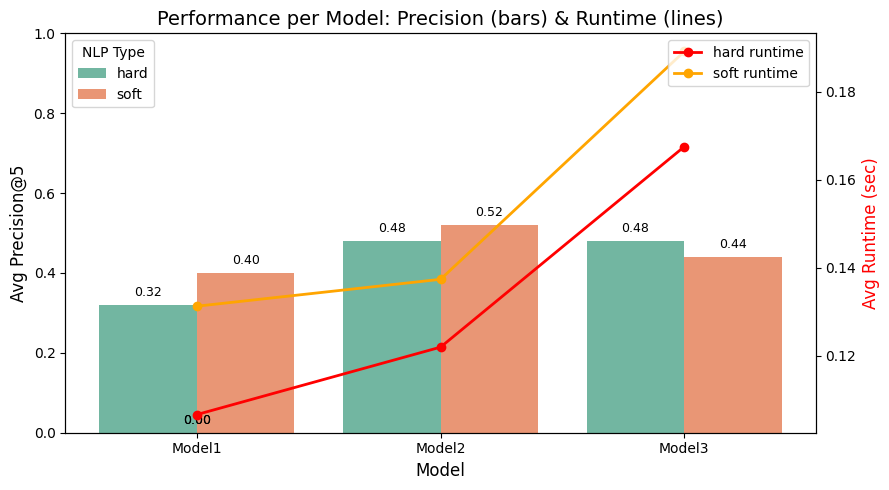

In [32]:
# Grouped performance per model & NLP
grouped = benchmark_df.groupby(['model','nlp']).agg({
    'precision@5': 'mean',
    'time_sec': 'mean'
}).reset_index()

# ensure consistent model order (use the models defined earlier)
model_order = list(model_options.keys())
nlp_types = sorted(grouped['nlp'].unique())  # e.g. ['hard','soft']

fig, ax1 = plt.subplots(figsize=(9,5))

# grouped bars: precision per model, split by nlp
sns.barplot(
    data=grouped,
    x='model',
    y='precision@5',
    hue='nlp',
    order=model_order,
    palette="Set2",
    ax=ax1
)

ax1.set_ylabel("Avg Precision@5", color="black", fontsize=12)
ax1.set_ylim(0, 1)
ax1.set_xlabel("Model", fontsize=12)
ax1.set_title("Performance per Model: Precision (bars) & Runtime (lines)", fontsize=14)

# annotate each bar with its precision value
for p in ax1.patches:
    height = p.get_height()
    if not np.isnan(height):
        ax1.annotate(f"{height:.2f}",
                     (p.get_x() + p.get_width() / 2., height),
                     ha='center', va='bottom', fontsize=9, xytext=(0, 4), textcoords='offset points')

# second y-axis for runtime
ax2 = ax1.twinx()
ax2.set_ylabel("Avg Runtime (sec)", color="red", fontsize=12)

# x positions for line plots (centered on each model)
x_pos = np.arange(len(model_order))

# plot runtime line for each NLP type
colors = ["red", "orange"]
for i, nlp in enumerate(nlp_types):
    times = [
        grouped[(grouped['model'] == m) & (grouped['nlp'] == nlp)]['time_sec'].values[0]
        if not grouped[(grouped['model'] == m) & (grouped['nlp'] == nlp)].empty else np.nan
        for m in model_order
    ]
    ax2.plot(x_pos, times, marker='o', color=colors[i % len(colors)], label=f"{nlp} runtime", linewidth=2)

# align x ticks to model positions
ax1.set_xticks(x_pos)
ax1.set_xticklabels(model_order)

# legends: keep bar (hue) legend and add runtime legend
handles1, labels1 = ax1.get_legend_handles_labels()
leg1 = ax1.legend(handles1, labels1, title='NLP Type', loc='upper left')
leg2 = ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


### Graph 2: Performance per Model
We will visualize the performance of each model variation using bar plots to compare precision@k.

C:\Users\dcjva\AppData\Local\Temp\ipykernel_10832\2601813918.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=stats, x='model', y='mean', palette="Set2", order=model_order, ci=None)
C:\Users\dcjva\AppData\Local\Temp\ipykernel_10832\2601813918.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=stats, x='model', y='mean', palette="Set2", order=model_order, ci=None)


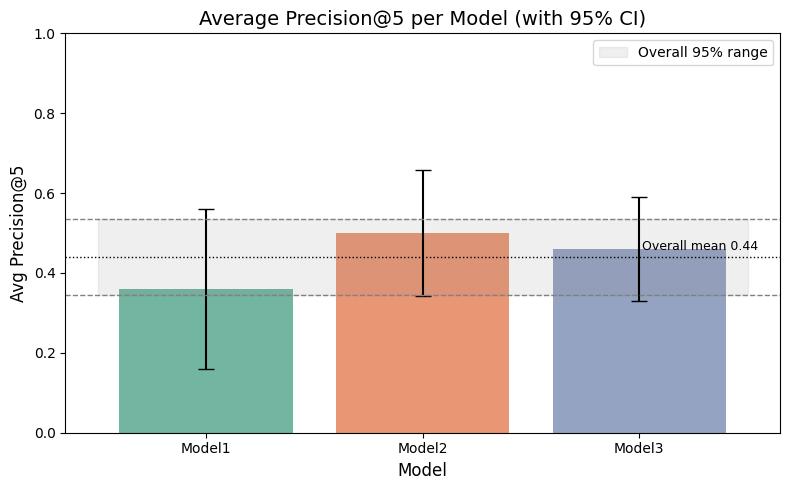

In [33]:
# Average Precision per Model with 95% CI (per-model) and overall 95% range band
z = 1.96  # z-score for ~95% CI

# compute per-model stats
stats = benchmark_df.groupby('model')['precision@5'].agg(['mean','count','std']).reset_index()
stats['sem'] = stats['std'] / np.sqrt(stats['count'])
stats['ci_low'] = stats['mean'] - z * stats['sem']
stats['ci_high'] = stats['mean'] + z * stats['sem']

# keep the model order consistent
stats = stats.set_index('model').loc[model_order].reset_index()

plt.figure(figsize=(8,5))
ax = sns.barplot(data=stats, x='model', y='mean', palette="Set2", order=model_order, ci=None)
ax.set_title("Average Precision@5 per Model (with 95% CI)", fontsize=14)
ax.set_ylabel("Avg Precision@5", fontsize=12)
ax.set_xlabel("Model", fontsize=12)
ax.set_ylim(0,1)

# add error bars using computed 95% CI
x_positions = [p.get_x() + p.get_width() / 2.0 for p in ax.patches]
ax.errorbar(x_positions, stats['mean'], yerr=[stats['mean'] - stats['ci_low'], stats['ci_high'] - stats['mean']],
      fmt='none', c='k', capsize=6)

# compute overall 95% range across all precision@5 values and show as horizontal band/lines
overall_mean = benchmark_df['precision@5'].mean()
overall_sem = benchmark_df['precision@5'].std(ddof=1) / np.sqrt(len(benchmark_df))
overall_ci_low = overall_mean - z * overall_sem
overall_ci_high = overall_mean + z * overall_sem

# draw lines and a light band for the overall 95% range
plt.axhline(overall_ci_low, color='gray', linestyle='--', linewidth=1)
plt.axhline(overall_ci_high, color='gray', linestyle='--', linewidth=1)
plt.fill_between([-0.5, len(stats)-0.5], overall_ci_low, overall_ci_high, color='gray', alpha=0.12, label='Overall 95% range')

# annotate the overall mean
plt.axhline(overall_mean, color='black', linestyle=':', linewidth=1)
plt.text(len(stats)-0.45, overall_mean + 0.01, f"Overall mean {overall_mean:.2f}", ha='right', va='bottom', fontsize=9)

plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

### Graph 3: Complete Comparison
We will visualize the complete comparison of all variations to identify the best-performing configuration for our recommendation system.

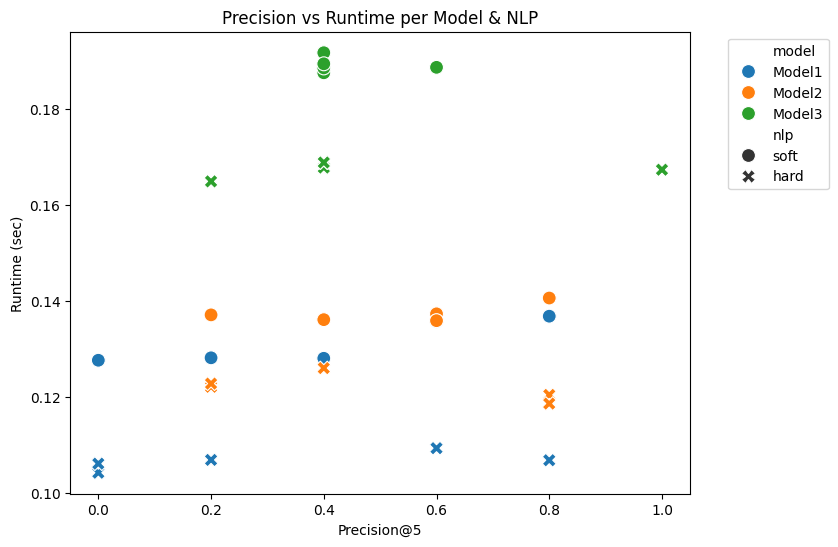

In [34]:
# Scatter Plot: Precision vs Runtime per Model & NLP
plt.figure(figsize=(8,6))
sns.scatterplot(data=benchmark_df, x='precision@5', y='time_sec', hue='model', style='nlp', s=100)
plt.title("Precision vs Runtime per Model & NLP")
plt.xlabel("Precision@5")
plt.ylabel("Runtime (sec)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


## Conclusion
After evaluating the different variations of embedding models, NLP preprocessing techniques, and their impact on performance metrics, we will summarize the findings and recommend the optimal configuration for our recommendation system.

### Findings
- Average metrics (all students & NLP types): Model1: precision@5 = 0.42 (≈0.136s), Model2: 0.54 (≈0.133s), Model3: 0.56 (≈0.182s).  
- Model3 yields the best overall accuracy; Model2 is nearly as accurate but consistently faster.  
- Per-student behavior varies: student1 achieves very high precision across models; students 2–3 benefit noticeably from Model2/Model3; students 4–5 show mixed results depending on NLP preprocessing (soft vs hard).  
- Soft vs Hard NLP preprocessing affects recommendations per domain — no single NLP choice is uniformly best across all students.